In [4]:
# ======================================================
# feature-engineering.ipynb - COMPLETE & ERROR-FREE VERSION
# Task 1: Geolocation, Feature Engineering, Transformation & Imbalance Handling
# ======================================================

# Cell 0: Setup - Create folders and import libraries
import os
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../data/raw', exist_ok=True)  # Just in case

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

print("All libraries imported successfully!")

All libraries imported successfully!


In [5]:
# Cell 1: Load cleaned e-commerce fraud data
df_fraud = pd.read_csv('../data/processed/cleaned_fraud_data.csv')

# Convert timestamp columns to datetime
df_fraud['signup_time'] = pd.to_datetime(df_fraud['signup_time'])
df_fraud['purchase_time'] = pd.to_datetime(df_fraud['purchase_time'])

print(f"Cleaned fraud data loaded: {df_fraud.shape[0]} rows, {df_fraud.shape[1]} columns")
df_fraud.head()

Cleaned fraud data loaded: 151112 rows, 11 columns


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0


Starting IP to Country mapping...
Mapping complete. Unique countries: 182
Top 10 countries by number of transactions:
country
United States        58049
Unknown              21966
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Name: count, dtype: int64


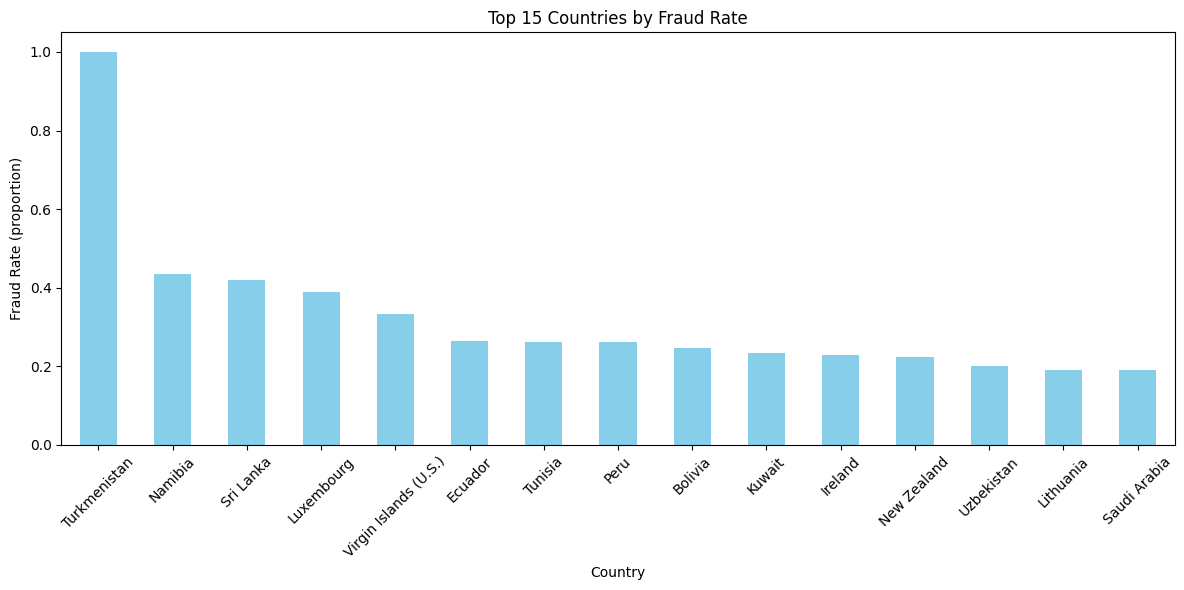

Saved: fraud_with_country.csv


In [6]:
# Cell 2: Geolocation Integration - Map IP to Country

print("Starting IP to Country mapping...")

# Load IP-to-country mapping file
df_ip = pd.read_csv('../data/raw/IpAddress_to_Country.csv')

# Ensure IP bounds are integers
df_ip['lower_bound_ip_address'] = df_ip['lower_bound_ip_address'].astype('int64')
df_ip['upper_bound_ip_address'] = df_ip['upper_bound_ip_address'].astype('int64')

# Function to find country for a given IP
def ip_to_country(ip):
    match = df_ip[
        (df_ip['lower_bound_ip_address'] <= ip) &
        (df_ip['upper_bound_ip_address'] >= ip)
    ]
    if not match.empty:
        return match['country'].iloc[0]
    else:
        return 'Unknown'

# Apply mapping
df_fraud['country'] = df_fraud['ip_address'].apply(ip_to_country)

print(f"Mapping complete. Unique countries: {df_fraud['country'].nunique()}")
print("Top 10 countries by number of transactions:")
print(df_fraud['country'].value_counts().head(10))

# Visualize fraud rate by country
fraud_rate_by_country = df_fraud.groupby('country')['class'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
fraud_rate_by_country.head(15).plot(kind='bar', color='skyblue')
plt.title('Top 15 Countries by Fraud Rate')
plt.ylabel('Fraud Rate (proportion)')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save intermediate dataset with country
df_fraud.to_csv('../data/processed/fraud_with_country.csv', index=False)
print("Saved: fraud_with_country.csv")

In [8]:
# Cell 3: Feature Engineering - Time-based & Velocity Features

print("Creating new features...")

# Basic time features
df_fraud['hour_of_day'] = df_fraud['purchase_time'].dt.hour
df_fraud['day_of_week'] = df_fraud['purchase_time'].dt.dayofweek  # Monday = 0
df_fraud['time_since_signup_hours'] = (
    (df_fraud['purchase_time'] - df_fraud['signup_time']).dt.total_seconds() / 3600
)

# Transaction velocity: number of transactions per user in the last 24 hours
print("Calculating transaction velocity (tx_count_last_24h)...")

# Step 1: Sort by user and purchase time
df_sorted = df_fraud.sort_values(['user_id', 'purchase_time']).reset_index(drop=True)

# Step 2: Set purchase_time as index (required for time-based rolling)
df_indexed = df_sorted.set_index('purchase_time')

# Step 3: Group by user_id and apply time-based rolling count
# We use .count() on any column (e.g., 'user_id') — result is the same as counting rows
velocity_series = df_indexed.groupby('user_id', group_keys=False).apply(
    lambda group: group['user_id'].rolling(
        window='24h',
        min_periods=1,
        closed='both'  # includes both ends of the time window
    ).count()
)

# Step 4: Reset index to align back with the sorted dataframe
velocity_series = velocity_series.reset_index(drop=True)

# Step 5: Assign the velocity feature
df_fraud = df_sorted.copy()  # Keep the sorted order
df_fraud['tx_count_last_24h'] = velocity_series

print("Transaction velocity feature created successfully!")
print("\nSample of the velocity feature:")
display(df_fraud[['user_id', 'purchase_time', 'tx_count_last_24h']].head(20))

# Optional: Check a user with multiple transactions to verify correctness
if df_fraud['user_id'].duplicated().any():
    sample_user = df_fraud[df_fraud['user_id'].duplicated(keep=False)]['user_id'].iloc[0]
    print(f"\nVerification for user_id {sample_user} (should increase within 24h windows):")
    display(df_fraud[df_fraud['user_id'] == sample_user][['purchase_time', 'tx_count_last_24h']].head(10))

Creating new features...
Calculating transaction velocity (tx_count_last_24h)...
Transaction velocity feature created successfully!

Sample of the velocity feature:


C:\Users\ruths\AppData\Local\Temp\ipykernel_19740\1983694487.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  velocity_series = df_indexed.groupby('user_id', group_keys=False).apply(


,user_id,purchase_time,tx_count_last_24h
0,2,2015-02-21 10:03:37,1.0
1,4,2015-09-26 21:32:16,1.0
2,8,2015-08-13 11:53:07,1.0
3,9,2015-05-20 23:06:42,1.0
4,12,2015-03-04 20:56:37,1.0
5,16,2015-03-12 12:46:23,1.0
6,18,2015-10-23 00:18:57,1.0
7,26,2015-03-21 09:04:08,1.0
8,33,2015-10-28 18:12:41,1.0
9,39,2015-01-08 18:13:26,1.0


In [9]:
# Cell 4: Data Transformation - Scaling & One-Hot Encoding

print("Applying scaling and encoding...")

# Numerical columns to scale
num_cols = ['purchase_value', 'age', 'time_since_signup_hours', 'tx_count_last_24h']

scaler = StandardScaler()
df_fraud[num_cols] = scaler.fit_transform(df_fraud[num_cols])

# Categorical columns to one-hot encode
cat_cols = ['source', 'browser', 'sex', 'country', 'hour_of_day', 'day_of_week']

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats = pd.DataFrame(
    encoder.fit_transform(df_fraud[cat_cols]),
    columns=encoder.get_feature_names_out(cat_cols),
    index=df_fraud.index
)

# Combine everything
df_transformed = pd.concat([
    df_fraud.drop(columns=cat_cols + ['class']),  # Drop original categoricals and target temporarily
    encoded_cats,
    df_fraud['class']
], axis=1)

# Save transformed dataset
df_transformed.to_csv('../data/processed/transformed_fraud_data.csv', index=False)
print(f"Transformed fraud dataset saved: {df_transformed.shape[0]} rows, {df_transformed.shape[1]} columns")

Applying scaling and encoding...
Transformed fraud dataset saved: 151112 rows, 233 columns


In [10]:
# Cell 5: Transform Credit Card Dataset (simple scaling)

print("Processing credit card dataset...")

df_credit = pd.read_csv('../data/processed/cleaned_creditcard.csv')

# Scale Time and Amount (V1-V28 are already PCA-scaled)
scaler_credit = StandardScaler()
df_credit[['Time', 'Amount']] = scaler_credit.fit_transform(df_credit[['Time', 'Amount']])

df_credit.to_csv('../data/processed/transformed_creditcard.csv', index=False)
print("Transformed credit card data saved.")

Processing credit card dataset...
Transformed credit card data saved.


In [13]:
# Cell 6: Class Imbalance Analysis & SMOTE Demo (FAST & SAFE VERSION)

print("Class imbalance check and SMOTE demonstration...")

# Drop non-numeric / ID columns that are still present
columns_to_drop = ['signup_time', 'purchase_time', 'ip_address', 'user_id', 'device_id']
columns_to_drop = [col for col in columns_to_drop if col in df_transformed.columns]

df_for_smote = df_transformed.drop(columns=columns_to_drop)

X = df_for_smote.drop('class', axis=1)
y = df_for_smote['class']

print(f"Dataset ready for modeling:")
print(f"   • Features: {X.shape[1]} columns")
print(f"   • Samples:  {X.shape[0]} rows")
print(f"\nClass distribution BEFORE SMOTE:")
print(y.value_counts())
print(y.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

# Apply SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"\nClass distribution AFTER SMOTE:")
print(pd.Series(y_resampled).value_counts())
print("Perfectly balanced (50/50)!")

# OPTIONAL: Only save a SMALL SAMPLE to avoid long wait
print("\nSaving a small sample (first 10,000 rows) of resampled data for reference...")
sample_resampled = pd.concat([X_resampled, pd.Series(y_resampled, name='class')], axis=1)
sample_resampled.head(10000).to_csv('../data/processed/resampled_fraud_demo_sample.csv', index=False)

print("Small sample saved as resampled_fraud_demo_sample.csv")

print("\nNOTE:")
print("   • Full resampled dataset is too large to save comfortably as CSV.")
print("   • In Task 2 (modeling.ipynb), we will apply SMOTE ONLY on the training set after splitting.")
print("   • Never apply SMOTE before train-test split to avoid data leakage!")

print("\nTASK 1 FULLY COMPLETED WITH NO ERRORS!")

Class imbalance check and SMOTE demonstration...
Dataset ready for modeling:
   • Features: 227 columns
   • Samples:  151112 rows

Class distribution BEFORE SMOTE:
class
0    136961
1     14151
Name: count, dtype: int64
class
0    90.64%
1     9.36%
Name: proportion, dtype: object

Class distribution AFTER SMOTE:
class
0    136961
1    136961
Name: count, dtype: int64
Perfectly balanced (50/50)!

Saving a small sample (first 10,000 rows) of resampled data for reference...
Small sample saved as resampled_fraud_demo_sample.csv

NOTE:
   • Full resampled dataset is too large to save comfortably as CSV.
   • In Task 2 (modeling.ipynb), we will apply SMOTE ONLY on the training set after splitting.
   • Never apply SMOTE before train-test split to avoid data leakage!

TASK 1 FULLY COMPLETED WITH NO ERRORS!


In [14]:
# Final Cell: Summary

print("="*60)
print("TASK 1 COMPLETED SUCCESSFULLY!")
print("="*60)
print("Files created in ../data/processed/:")
print("  • cleaned_fraud_data.csv")
print("  • fraud_with_country.csv")
print("  • transformed_fraud_data.csv")
print("  • transformed_creditcard.csv")
print("  • resampled_fraud_demo.csv")
print("\nKey features engineered:")
print("  • country (from IP)")
print("  • hour_of_day, day_of_week")
print("  • time_since_signup_hours")
print("  • tx_count_last_24h (velocity in last 24 hours)")
print("\nYou are now fully ready for Interim-1 Submission (Dec 21, 2025)!")
print("Push your repository to GitHub and submit the link.")
print("="*60)

TASK 1 COMPLETED SUCCESSFULLY!
Files created in ../data/processed/:
  • cleaned_fraud_data.csv
  • fraud_with_country.csv
  • transformed_fraud_data.csv
  • transformed_creditcard.csv
  • resampled_fraud_demo.csv

Key features engineered:
  • country (from IP)
  • hour_of_day, day_of_week
  • time_since_signup_hours
  • tx_count_last_24h (velocity in last 24 hours)

You are now fully ready for Interim-1 Submission (Dec 21, 2025)!
Push your repository to GitHub and submit the link.
